# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/Ben/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [9]:
book_filenames = sorted(glob.glob("got/*.txt"))

In [10]:
print("Found books:")
book_filenames

Found books:


['got/got1.txt',
 'got/got2.txt',
 'got/got3.txt',
 'got/got4.txt',
 'got/got5.txt']

**Combine the books into one string**

In [11]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'got/got1.txt'...
Corpus is now 1770658 characters long

Reading 'got/got2.txt'...
Corpus is now 4071039 characters long

Reading 'got/got3.txt'...
Corpus is now 6391402 characters long

Reading 'got/got4.txt'...
Corpus is now 8107941 characters long

Reading 'got/got5.txt'...
Corpus is now 9719480 characters long



**Split the corpus into sentences**

In [12]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [13]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [14]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [15]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [16]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [17]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [18]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [19]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [20]:
thrones2vec.build_vocab(sentences)

2019-06-04 14:56:58,277 : INFO : collecting all words and their counts
2019-06-04 14:56:58,281 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-06-04 14:56:58,331 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2019-06-04 14:56:58,405 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2019-06-04 14:56:58,490 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2019-06-04 14:56:58,541 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2019-06-04 14:56:58,606 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2019-06-04 14:56:58,643 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2019-06-04 14:56:58,717 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2019-06-04 14:56:58,772 : INFO : PROGRESS: at 

In [21]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [22]:
thrones2vec.train(sentences, total_words=thrones2vec.corpus_count, epochs=5)

2019-06-04 14:57:03,002 : INFO : training model with 4 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-06-04 14:57:04,044 : INFO : EPOCH 1 - PROGRESS: at 193.82% words, 187820 words/s, in_qsize 7, out_qsize 0
2019-06-04 14:57:05,066 : INFO : EPOCH 1 - PROGRESS: at 418.31% words, 203289 words/s, in_qsize 7, out_qsize 0
2019-06-04 14:57:06,101 : INFO : EPOCH 1 - PROGRESS: at 650.78% words, 210222 words/s, in_qsize 7, out_qsize 0
2019-06-04 14:57:07,128 : INFO : EPOCH 1 - PROGRESS: at 875.56% words, 212424 words/s, in_qsize 7, out_qsize 0
2019-06-04 14:57:08,146 : INFO : EPOCH 1 - PROGRESS: at 1108.01% words, 215258 words/s, in_qsize 8, out_qsize 0
2019-06-04 14:57:09,194 : INFO : EPOCH 1 - PROGRESS: at 1340.33% words, 216029 words/s, in_qsize 7, out_qsize 0
2019-06-04 14:57:09,416 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-06-04 14:57:09,425 : INFO : worker thread finished; awaiting finish of 2 more threads


(7022421, 9090515)

**Save to file, can be useful later**

In [23]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [24]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-06-04 15:00:29,012 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-06-04 15:00:29,014 : INFO : not storing attribute vectors_norm
2019-06-04 15:00:29,017 : INFO : not storing attribute cum_table
2019-06-04 15:00:29,018 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-04 15:00:29,606 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [87]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2019-05-25 18:09:40,828 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2019-05-25 18:09:40,830 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-25 18:09:41,092 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2019-05-25 18:09:41,093 : INFO : setting ignored attribute vectors_norm to None
2019-05-25 18:09:41,093 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2019-05-25 18:09:41,094 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2019-05-25 18:09:41,095 : INFO : setting ignored attribute cum_table to None
2019-05-25 18:09:41,097 : INFO : loaded trained/thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [88]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [89]:
all_word_vectors_matrix = thrones2vec.wv.vectors

**Train t-SNE, this could take a minute or two...**

In [90]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [91]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [92]:
points.head(10)

,word,x,y
0,THE,13.567080,81.894943
1,by,-70.177826,-13.543784
2,William,-26.703974,26.516563
3,Shakespeare,-25.980530,26.707542
4,From,-65.082428,-4.825394
5,fairest,-48.743336,17.706987
6,creatures,-34.209187,36.951488
7,we,-61.104530,-37.030857
8,desire,-66.895607,-34.642776
9,increase,-55.667297,8.704184


In [93]:
sns.set_context("poster")

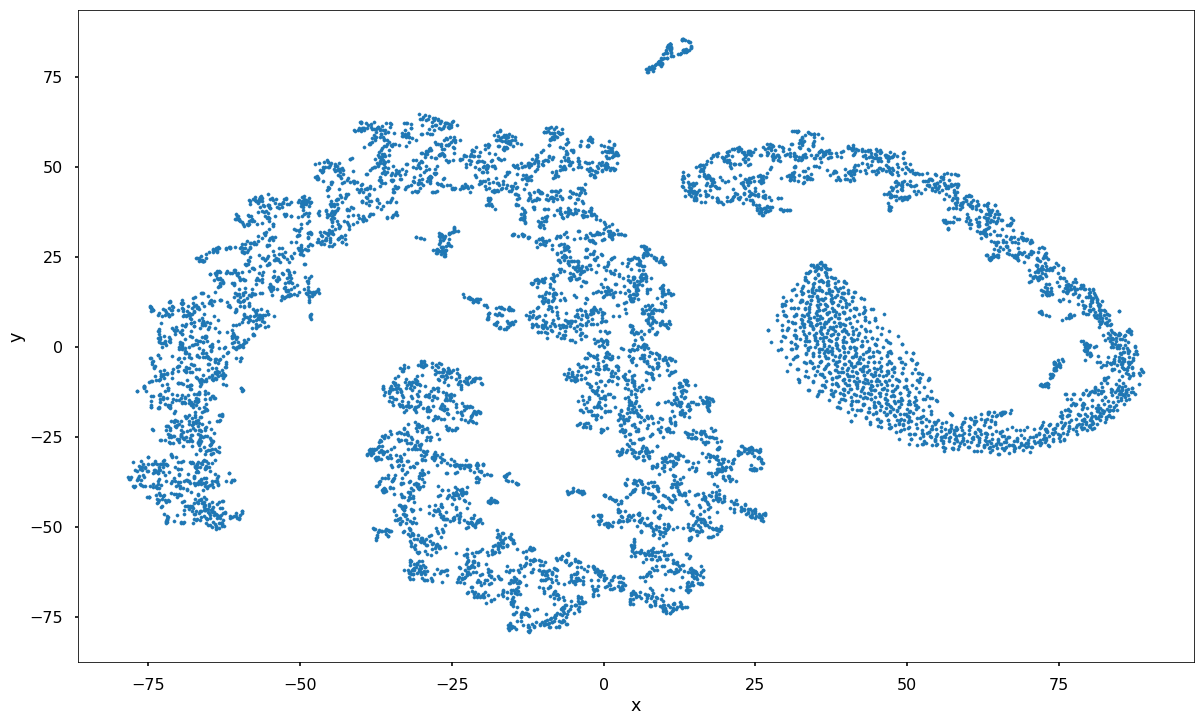

In [94]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [95]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

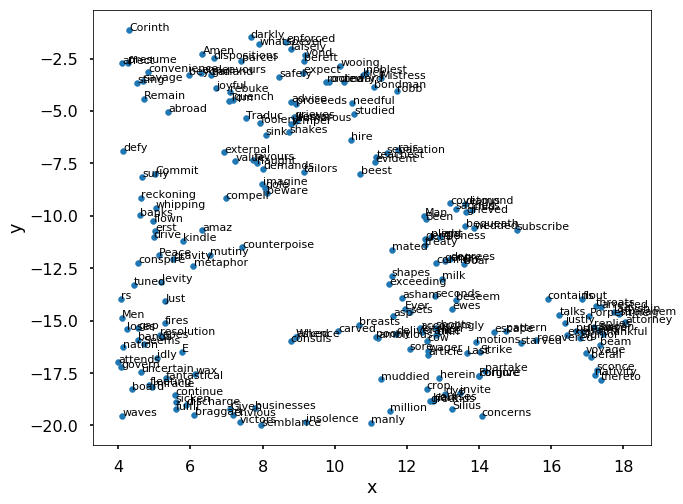

In [96]:
plot_region(x_bounds=(4.0, 20), y_bounds=(-20, -1))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

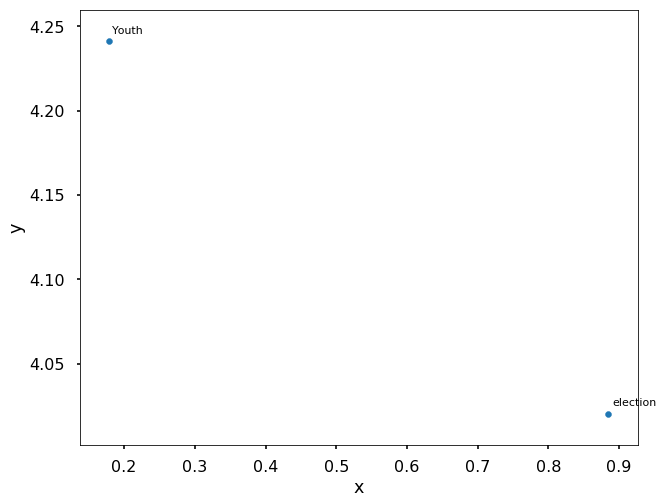

In [97]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [102]:
thrones2vec.wv.most_similar("throng")

[('embracements', 0.9981220364570618),
 ('Lartius', 0.9981158971786499),
 ('impossibility', 0.9981139898300171),
 ('Alexas', 0.9981057643890381),
 ('brass', 0.9980974197387695),
 ('Oliver', 0.9980965852737427),
 ('thievish', 0.9980887174606323),
 ('used', 0.9980873465538025),
 ('allow', 0.9980868101119995),
 ('trifle', 0.9980864524841309)]

In [67]:
thrones2vec.wv.most_similar("Aerys")

[('Targaryen', 0.9789420366287231),
 ('tourney', 0.9788704514503479),
 ('death', 0.9730523824691772),
 ('murdered', 0.9726494550704956),
 ('Rhaegar', 0.9699712991714478),
 ('Winterfell', 0.9697175025939941),
 ('Edmure', 0.9686864018440247),
 ('Eddard', 0.9684844613075256),
 ('Renly', 0.9676513671875),
 ('Robert', 0.9670567512512207)]

In [66]:
thrones2vec.wv.most_similar("direwolf")

[('short', 0.9786844849586487),
 ('third', 0.9773012399673462),
 ('giant', 0.9755905866622925),
 ('rage', 0.9746553301811218),
 ('hole', 0.9746004343032837),
 ('body', 0.9743128418922424),
 ('axe', 0.9730913639068604),
 ('built', 0.9712137579917908),
 ('hers', 0.9703989624977112),
 ('holding', 0.970307469367981)]

**Linear relationships between word pairs**

In [63]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [64]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Robb is related to Riverrun
Jaime is related to sword, as Littlefinger is related to wine
Arya is related to Nymeria, as Yoren is related to dragons


'Yoren'